# Labels Profiling
This notebook shows a preliminary exploration of the labels, written with the COCO Keypoint 1.0 format.<br>
In this format we have a number for the class, that is always 0 because we care only about foosball tables, 4 numbers for the bounding box (coordinates for the center, width and height) and the variuos keypoints rapresented as (x, y, v), where x and y are simply the coordinates and v is the visibility (2 means visible, 1 means not visible and 0 means not present).

For a foosball table we have 8 keypoints: the first 4 form the upper rectangle, and the last 4 form the lower rectangle (the play area)<br>
We also need the upper rectangle because in some images, some vertices of the lower rectangle are cut out from the image, and so we will use the upper rectangle to build the lower rectangle.

## Setup
Execute this cell before the other ones.

In [1]:
import pandas as pd
import sys
sys.path.append('..')
from src.config import *

df = pd.read_parquet(LABELS_DATAFRAME_DIRECTORY)

## Centers and Directions Analysis

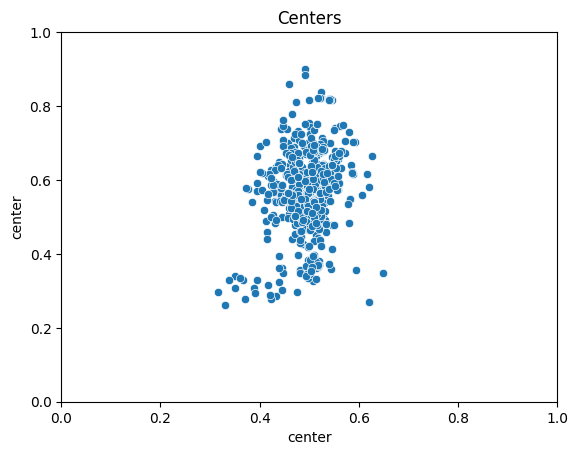

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df, x=df['center'].str[0], y=df['center'].str[1])
plt.title("Centers")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()


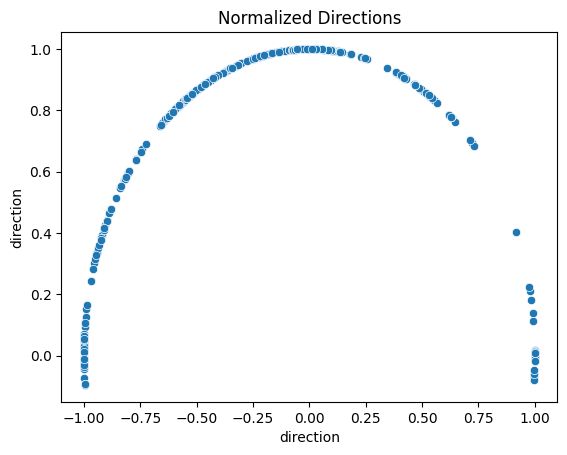

In [3]:
sns.scatterplot(data=df, x=df['direction'].str[0], y=df['direction'].str[1])
plt.title("Normalized Directions")
plt.show()

In [4]:
'''
query to remove
filtered = df[
    df['direction'].apply(lambda d: 0.5 <= d[0] <= 1.0 and 0.0 <= d[1] <= 0.5)
]

# restituisco solo i filename
result = filtered['filename'].tolist()
print(len(result))
for r in result:
    print(r)
'''


"\nquery to remove\nfiltered = df[\n    df['direction'].apply(lambda d: 0.5 <= d[0] <= 1.0 and 0.0 <= d[1] <= 0.5)\n]\n\n# restituisco solo i filename\nresult = filtered['filename'].tolist()\nprint(len(result))\nfor r in result:\n    print(r)\n"